Image segmentation is the task of labelling pixels of objects of interest in an image.

In this tutorial, we will see how to segment objects from background. We use the `coins` image from the `skimage.data` module. This image shows several coins outlined against a darker background. The segmentation of the coins cannot be done directly from the histogram of grey values, because the background shares enough gray levels with the coins that a thresholding segmentation is not sufficient.

In [1]:
from skimage import data
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coins = data.coins()
hist, hist_centers = histogram(coins)

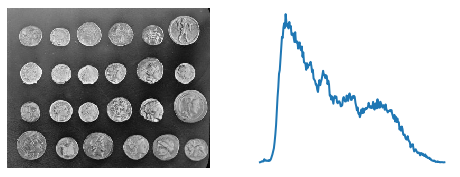

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].imshow(coins, cmap='gray')
axes[1].plot(hist_centers, hist, lw=2)

for ax in axes:
    ax.axis('off')

Simply thresholding the image leads either to missing significant parts of the coins or to merging parts of background with the coins. This is due to the inhomogeneous lighting of the image.

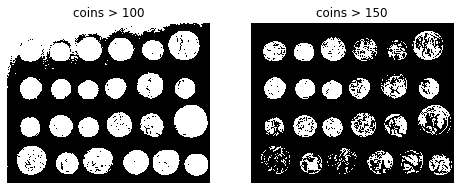

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].imshow(coins > 100, cmap='gray')
axes[1].imshow(coins > 150, cmap='gray')
titles = ['coins > 100', 'coins > 150']

for ax, title in zip(axes, titles):
    ax.axis('off')
    ax.set_title(title)

Take a few minutes if you can think of an algorithm to automatically determine what the ideal threshold would be. See if you can code it up using either Python or pseudo-code (code but with words and phrases instead of actual Python commands)

In [ ]:
T = 100
tol = 100
while tol > 0.1:
    mu1 = np.average(im[im>T])
    mu2 = np.average(im[im<=T])
    mua = 0.5*(mu1+mu2)
    tol = np.abs(T - mua)
    print(tol)
    T = mua

## Edge-based segmentation

Next, we try to delineate the contours of the coins using edge-based segmentation. To do this, we first get the edges of features using the Canny edge detector.

In [5]:
from skimage.feature import canny
from skimage.morphology import disk, binary_dilation, binary_erosion

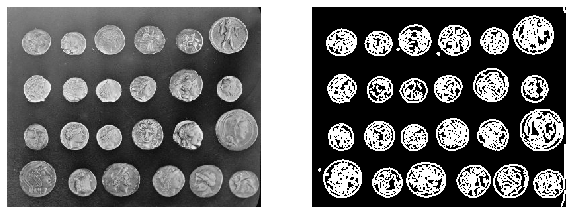

In [6]:
edges = canny(coins)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(binary_dilation(edges, disk(1)), cmap='gray')

for ax in axes:
    ax.axis('off')

These contours are then filled using mathematical morphology

In [7]:
from scipy.ndimage import binary_fill_holes

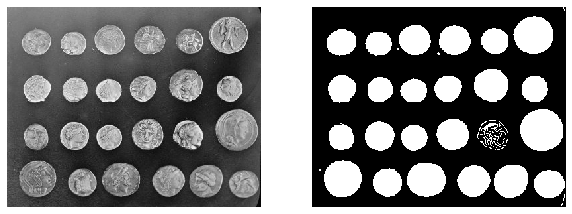

In [32]:
fill_coins = binary_fill_holes(edges)

#fill_coins = binary_erosion(binary_fill_holes(binary_dilation(edges, disk(1))))


fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(fill_coins, cmap='gray')

for ax in axes:
    ax.axis('off')

Small spurious objects are easily removed by setting a minimum size for valid objects:

In [9]:
from skimage.morphology import remove_small_objects

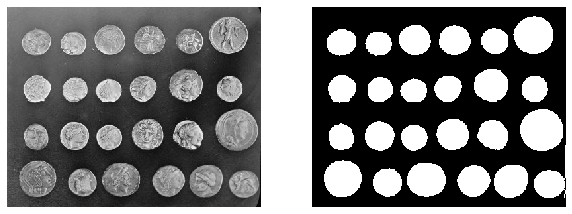

In [10]:
coins_cleaned = remove_small_objects(fill_coins, 21)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(coins_cleaned, cmap='gray')

for ax in axes:
    ax.axis('off')

However, this method is not very robust, since contours that are not perfectly closed are not filled, as is the case for on unfilled coin above.

## Region-based segmentation

We therefore try a region-based method using the watershed transform. First, we find an elevation map using the Sobel gradient of the image (remember, the Sobel gradient is an approximation of the first derivative of an image).

In [11]:
from skimage.filters import sobel, rank

C:\Users\koolk\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


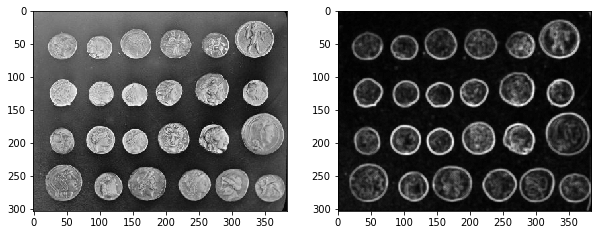

In [24]:
elevation_map = sobel(coins)
#elevation_map = closing(sobel(coins), disk(2))
elevation_map = rank.mean(elevation_map, disk(2))

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(elevation_map, cmap='gray')

# for ax in axes:
#     ax.axis('off')

In [13]:
from mpl_toolkits.mplot3d import Axes3D

In [14]:
elevation_map.shape

(303, 384)

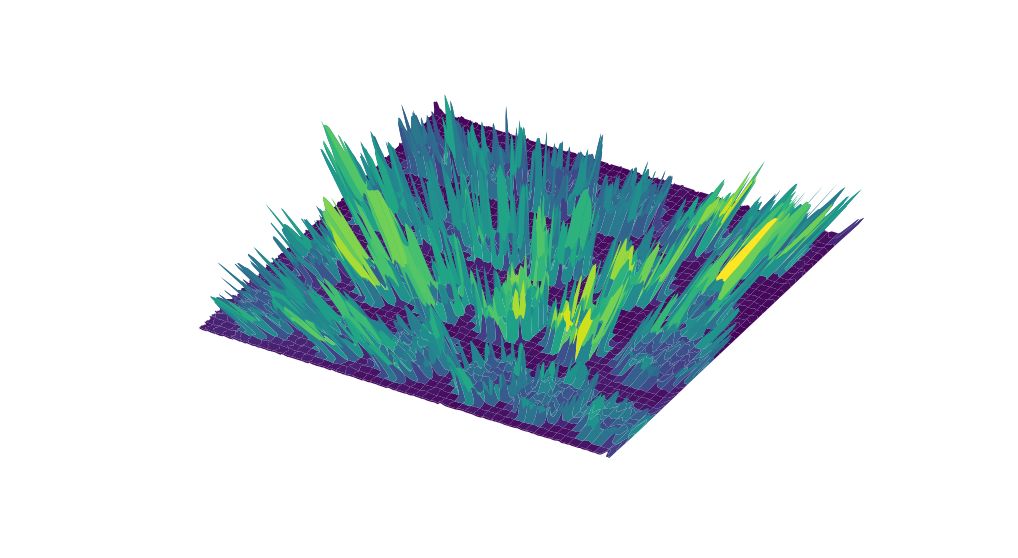

In [15]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')

Nx, Ny = (coins.shape[1], coins.shape[0])
xi = np.linspace(0, Nx-1, Nx)
yi = np.linspace(0, Ny-1, Ny)
x, y = np.meshgrid(xi, yi)

ax.plot_surface(y, x, elevation_map, cmap='viridis')
ax.axis('off')
ax.set_zlim([0, 30])

ax.view_init(85, 30)

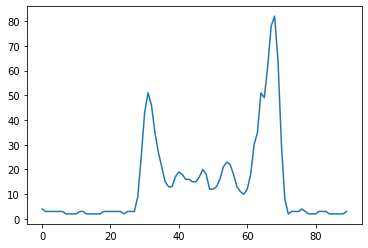

In [29]:
plt.plot(elevation_map[75:165, 200])

Next, we find markers of the background and the coins based on the extreme parts of the histogram of gray values.

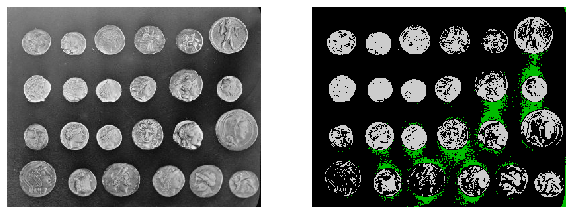

In [16]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1 #these are the low intensities
markers[coins > 150] = 2 # these are the high intensities

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(markers, cmap='nipy_spectral')

for ax in axes:
    ax.axis('off')

Note that if we had overlapping coins, this may not have been the best way to define our markers. If you want to distinguish between coins that are overlapping, each coin would have to have a different marker. You can look at a distance-based method for determining markers in [this example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html).

Finally, we use the watershed transform to fill regions of the elevation map starting from the markers determined above. Background will be filled from the green spots. Coins will be filled from the gray spots.

In [17]:
from skimage.morphology import watershed, opening, closing
from skimage.util import invert

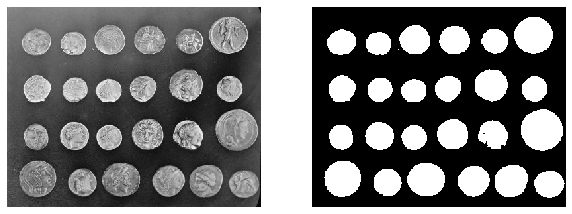

In [31]:
#segmentation = closing(watershed(elevation_map, markers), disk(3))
segmentation = watershed(elevation_map, markers)
#segmentation = remove_small_objects(segmentation, 101)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(coins, cmap='gray')
axes[1].imshow(segmentation, cmap='gray')

for ax in axes:
    ax.axis('off')

This last method works even better, and the coins can be segmented and labeled individually.

In [19]:
from skimage.color import label2rgb
from scipy.ndimage import label

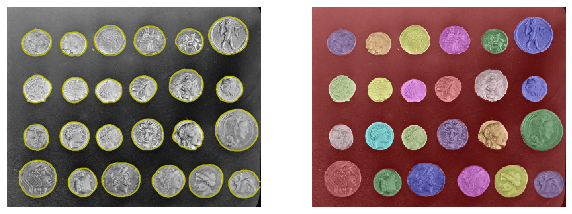

In [20]:
#segmentation = binary_fill_holes(segmentation - 1)
labeled_coins, _ = label(1-segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, axes = plt.subplots(1, 2, figsize=(10,6), sharey=True)

axes[0].imshow(coins, cmap='gray')
axes[0].contour(segmentation, [0.5, 1.2], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for ax in axes:
    ax.axis('off')

The really cool thing about the `labeled_coins` object is that you can now extract properties of individual objects within the image:

In [21]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [22]:
props = ('area', 'major_axis_length', 'minor_axis_length', 'mean_intensity')
regions = pd.DataFrame(regionprops_table(labeled_coins, coins, props))
regions = regions.drop(6)

In [23]:
regions

,area,major_axis_length,minor_axis_length,mean_intensity
0,2564,58.678185,55.658903,157.235179
1,1623,46.512904,44.456068,169.998152
2,1589,46.586980,43.457355,158.232851
3,1198,40.710880,37.535698,154.770451
4,1334,44.540893,38.173761,168.257121
5,1093,39.350805,35.414504,184.618481
7,1899,50.644604,47.796896,159.116377
8,1297,42.032003,39.420691,190.637625
9,1192,40.731246,37.338749,172.625000
10,1156,39.151873,37.621530,170.590830
